### Helping functions

In [2]:
# Function for tagging residues as LIP/non-LIP
# Overwrites entries in the second dataset with LIP flag from the first dataset
def LIP_tag(ds_original, ds_residues):
    #For every protein we take the information of where LIP residue are
    for idx, row in ds_original.iterrows():
        # Bind information to correct variables
        pdb, chain, start, end = (row[0:4])
        # Get the correct slice of data which will be edited
        sliced = ((ds_residues['PDB_ID'] == pdb) 
                    & (ds_residues['CHAIN_ID'] == chain) 
                    & (ds_residues['RES_ID'] <= end) 
                    & (ds_residues['RES_ID'] >= start))
        #Now we set to 1 all the residue whose features are the one desired 
        ds_residues.loc[sliced, 'LIP'] = 1
        ds_residues.loc[sliced, 'LIP_SCORE'] = 1
        
def down_sampling(df, number_of_samples, seed = 42):
    noLIP_index = set(df[df['LIP'] == 0].index)
    indexes = set(np.arange(0, np.shape(df)[0]))
    sample = random.sample(noLIP_index, len(noLIP_index) - number_of_samples)
    new_index = indexes.difference(sample)
    df1 = df.iloc[list(new_index), :]
    return df1

### Importing libraries

In [17]:
# Import default libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
import random
import warnings
# Import Biopython utils
from Bio.PDB import PDBList, is_aa, PDBIO
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select

### Importing original dataset (LIP tagged sequences)

In [4]:
# Read original dataset (lips_dataset)
ds_original = pd.read_csv('./datasets/lips_dataset.txt', sep='\t')
# Define new dataset
ds_original.head()

,pdb,chain,start,end,type
0,1cee,B,1,47,long
1,1dev,B,669,709,long
2,1dow,B,118,148,long
3,1fqj,C,63,87,long
4,1g3j,B,2,29,long


### Downloading proteins (automatically skips a protein if it has already been downloaded)

In [5]:
# Select all proteins (pdb column)
pdb_ids = ds_original.pdb.unique()
# Define pdb files dir
pdb_dir = './pdb_files'
# Define pdb file fetching class
pdbl = PDBList()
# Fetch every protein
for pdb_id in pdb_ids:
    # Execute fetching of the protein (pdb file)
    pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format='pdb')

Structure exists: './pdb_files/pdb1cee.ent' 
Structure exists: './pdb_files/pdb1dev.ent' 
Structure exists: './pdb_files/pdb1dow.ent' 
Structure exists: './pdb_files/pdb1fqj.ent' 
Structure exists: './pdb_files/pdb1g3j.ent' 
Structure exists: './pdb_files/pdb1hrt.ent' 
Structure exists: './pdb_files/pdb1i7w.ent' 
Structure exists: './pdb_files/pdb1j2j.ent' 
Structure exists: './pdb_files/pdb1jsu.ent' 
Structure exists: './pdb_files/pdb1kil.ent' 
Structure exists: './pdb_files/pdb1l8c.ent' 
Structure exists: './pdb_files/pdb1p4q.ent' 
Structure exists: './pdb_files/pdb1pq1.ent' 
Structure exists: './pdb_files/pdb1q68.ent' 
Structure exists: './pdb_files/pdb1rf8.ent' 
Structure exists: './pdb_files/pdb1sc5.ent' 
Structure exists: './pdb_files/pdb1sqq.ent' 
Structure exists: './pdb_files/pdb1tba.ent' 
Structure exists: './pdb_files/pdb1th1.ent' 
Structure exists: './pdb_files/pdb1xtg.ent' 
Structure exists: './pdb_files/pdb1ymh.ent' 
Structure exists: './pdb_files/pdb1zoq.ent' 
Structure 

### Creating redidues dataset

In [6]:
# Select all proteins (pdb column)
pdb_ids = ds_original.pdb.unique()
# Define pdb files dir
pdb_dir = './pdb_files'
# Define pdb file fetching class
pdbl = PDBList()

In [7]:
# Define a set containing (pdb_id, chain_id)
valid_chains = set([(row['pdb'], row['chain']) for idx, row in ds_original.iterrows()])

In [10]:
# New list for residues
ds_residues = list()
# Loop thorugh every protein
for pdb_id in ds_original.pdb.unique():
    # Get structure of the protein
    structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
    # We select only the 0-th model
    model = structure[0]
    # Loop through every model's chain
    for chain in model:
        # Skip if the chain is not valid
        if (pdb_id, chain.id) not in valid_chains:
            continue
        for residue in chain:
            # Do not take into account non-aminoacidic residues (e.g. water molecules)
            if(not is_aa(residue)): 
                continue
            # Add an entry to the residues list
            ds_residues.append((pdb_id, model.id, chain.id, residue.id[1], residue.get_resname(), 0, 0))

                                   
# Turn list into dataframe
ds_residues = pd.DataFrame(ds_residues)
# Define dataset column names
ds_residues.columns = ['PDB_ID', 'MODEL_ID', 'CHAIN_ID', 'RES_ID', 'RES_NAME', 'LIP_SCORE', 'LIP']
# Show some info about the dataset
print("Numbers of proteins: {}".format(np.shape(ds_original)[0]))
print("Numbers of res: {}".format(np.shape(ds_residues)[0]))
# Show first rows
ds_residues.head()

Numbers of proteins: 83
Numbers of res: 2367


,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP
0,1cee,0,B,1,LYS,0,0
1,1cee,0,B,2,LYS,0,0
2,1cee,0,B,3,LYS,0,0
3,1cee,0,B,4,ILE,0,0
4,1cee,0,B,5,SER,0,0


### Tagging LIP residues

In [12]:
# Launch tagging algorithm: we have 0 positively tagged residues
LIP_tag(ds_original, ds_residues)
# Check that the number of residues positively LIP-tagged is higher than 0
assert True, any(ds_residues['LIP'] == 1)
# Show first positively tagged LIP residues
ds_residues.head(100)

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP
0,1cee,0,B,1,LYS,1,1
1,1cee,0,B,2,LYS,1,1
2,1cee,0,B,3,LYS,1,1
3,1cee,0,B,4,ILE,1,1
4,1cee,0,B,5,SER,1,1
5,1cee,0,B,6,LYS,1,1
6,1cee,0,B,7,ALA,1,1
7,1cee,0,B,8,ASP,1,1
8,1cee,0,B,9,ILE,1,1
9,1cee,0,B,10,GLY,1,1


### Check dataset balancement

We check if we have the same numerosity of LIP and npn-LIP tagged residues.

In [26]:
# Compute numerosity of LIP tagged residues
print('Numerosity of LIP tagged residues: {}'.format(ds_residues[ds_residues.LIP == 1].shape[0]))
# Compute numerosity of non-LIP tagged residues
print('Numerosity of non-LIP tagged residues: {}'.format(ds_residues[ds_residues.LIP == 0].shape[0]))

Numerosity of LIP tagged residues: 1897
Numerosity of non-LIP tagged residues: 470


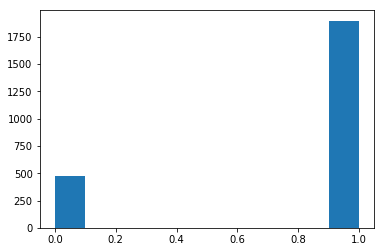

In [35]:
# Add plot
fig, ax = plt.subplots(1, 1)
# Add frequency plot
fig = plt.hist(ds_residues['LIP'])